# Set up work space


In [1]:
# import data into notebook and change to directory
import os 
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/AML flight prediction /code') # current directory

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
del gpu_info

Wed Jul 27 10:26:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
del ram_gb

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
# # to upload directly to kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !pip install kaggle # to submit from google collab

### install packages

In [4]:
pip install timezonefinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45.7 MB 1.7 MB/s 
     |████████████████████████████████| 1.1 MB 55.0 MB/s 


### import modules

In [5]:
# general use
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt

# time manipulation
import pytz
from timezonefinder import TimezoneFinder
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# modeling
import lightgbm as lgb
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score

pd.set_option('display.max_columns', None)  # return all columns


# Import and Manipulate Data

In [6]:
# functions used to import .csvs
def import_airlines(path):
  '''
  @author: Jon Harris
  '''
  return pd.read_csv(path)\
             .rename(columns=str.lower)\
             .rename(columns={'iata_code': 'airline_code'})


def import_airports(path):
  '''
  @author: Jon Harris
  '''
  df = pd.read_csv(path, low_memory=False)
  df.rename(columns=str.lower, inplace=True)
  df.rename(columns={'iata_code': 'airport_code',
                      'origin_airport': 'origin_airport_code',
                      'destination_airport': 'destination_airport_code'}, inplace=True)
  
  # impute missing latitdue and longitude
  lat_imput = dict(zip(['ECP', 'PBG', 'UST'], [30.3549, 44.6521, 29.9544]))
  lat_idx = df[df['latitude'].isna()].index
  df.at[lat_idx, 'latitude'] = df['airport_code'].loc[lat_idx].map(lat_imput)

  long_imput = dict(zip(['ECP', 'PBG', 'UST'], [85.7995, 73.4679, 81.3429]))
  long_idx = df[df['longitude'].isna()].index
  df.at[lat_idx, 'longitude'] = df['airport_code'].loc[long_idx].map(long_imput)

  # add timezone using latitude and longitude data
  tz_obj = TimezoneFinder()
  get_timezone = lambda lat,lng: tz_obj.timezone_at(lat=lat, lng=lng)
  df['tz'] = np.vectorize(get_timezone)(df['latitude'], df['longitude']) # add timezone

  return df.drop(['country','airport','city','state'], axis=1) 


def import_predictors(path):
  '''
  used to import train and test datasets
  @author: Jon Harris
  '''
  df = pd.read_csv(path, low_memory=False)
  df.rename(columns=str.lower, inplace=True)
  df.rename(columns={'airline': 'airline_code',
                      'origin_airport': 'origin_airport_code',
                      'destination_airport': 'destination_airport_code'}, inplace=True)
  
  # correct time integers
  df['scheduled_departure'].replace({2400: 0}, inplace=True)
  df['departure_time'].replace({2400: 0}, inplace=True)
  df['scheduled_arrival'].replace({2400: 0}, inplace=True)

  return df




In [7]:
# functions used for feature engineering

def timezone_diff(day,month, year, origin, destination):
  '''
  extract hour difference between cities on given day 
  - accounts for daylight savings

  @author: Jon Harris
  '''
  date = datetime(year = year,
                  month = month,
                  day = day) # create datetime object

  # create pytz timezone objects
  origin_tz = pytz.timezone(origin)
  dest_tz = pytz.timezone(destination)

  # create timestamps
  origin_ts = origin_tz.localize(date)
  dest_ts = dest_tz.localize(date)

  # package doesn't recognize Guam -- correct GUM-HNL flights
  if (origin=='Pacific/Honolulu') & (destination=='Etc/GMT+10'):
    return +20
  elif (origin=='Etc/GMT+10') & (destination=='Pacific/Honolulu'):
    return -20

  return int(dest_ts.strftime('%z'))/100 - int(origin_ts.strftime('%z'))/100 #hr difference



def local_timestamp(day,month,year,int_time,timezone=None):
  '''
  create local timestamp (@origin) based on provided calendar information
  @author: Jon Harris
  '''
  ts = datetime(year = year,
                month = month,
                day = day,
                hour = int(int_time//100),
                minute = int(int_time%100)) # timestamp
  tz = pytz.timezone(timezone) # localize timezone (otherwise reports avg)
  return tz.localize(ts) # add timestamp to timezone



def adjust_departure_ts(scheduled, actual):
  '''
  assume provided calendar information belongs to scheduled_departure
  actual departure_time may occur on previous day or day after (if close to midnight)
  @author: Jon Harris
  '''
  delta = actual-scheduled 
  delta_hours = delta.total_seconds()/3600

  # assumes that flights don't leave 2hrs early
  # assumes delay not >24hrs
  cutoff = 2
  if delta_hours < -cutoff:
    actual = actual+timedelta(days=1)
  elif delta_hours > 24-cutoff:
    actual = actual-timedelta(days=1)

  return actual



def departure_delay(scheduled,actual):
  '''
  if scheduled < actual --> +total_mins
  if scheduled > actual --> -total_mins

  @author: Jon Harris
  '''

  # remove timezone
  scheduled = scheduled.replace(tzinfo=None)
  actual = actual.replace(tzinfo=None)

  return (actual-scheduled).total_seconds()/60



def round_timestamp(ts, nearest=60):
  '''
  round timestamp to nearest __minutes
  - feature used to bin flights by the current hour
  @author: Jon Harris
  '''
  ts = ts.replace(tzinfo = None) # remove timestamp
  minutes = ts.minute # extract minutes
  mod = timedelta(minutes = minutes%nearest) # remainder
  ts -= mod # default - round down

  # if closer to ts+nearest --> add nearest
  if mod >= timedelta(minutes=nearest/2):
    return ts + timedelta(minutes = nearest) 

  return ts



def delta_time(depart, arrival): 
  '''
  calculate the difference between two times
  @author: Dimka Dellenbag
  '''

  return (depart.replace(tzinfo=None)-arrival.replace(tzinfo=None)).total_seconds()/60


def reduce_mem_usage(X_mat, verbose=True):
    '''
    pandas dataframes are large --> must reduce RAM usage
    reduce memory usage of dataframe
    @added by: Jon Harris
    @author: https://towardsdatascience.com/how-to-work-with-million-row-datasets-like-a-pro-76fb5c381cdd
    '''
    df = X_mat.copy()
    
    numerics = ['int8', 'int16', 'int32',
                'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [8]:
# pipeline that calculates all novel features

def feature_engineering(X_mat):
  ''' 
  executes all feature engineering for train-test data
  @author: Jon Harris
  '''

  df = X_mat.copy()

  # create is_MonFri boolean feature
  ## Monday and Friday are busiest days (not weekend)
  ### train.groupby('day_of_week').size().sort_values(ascending=False)
  df['is_Mon'] = df['day_of_week'] == 1

  # create is_summer boolean feature
  ## Jan-Feb lowest months
  df['is_summer'] = (df['month'] >= 5) & (df['month'] <= 8)  # May-Aug
  df['is_winter'] = (df['month'] == 1) & (df['month'] == 1) # Jan-Feb

  # calculate timezone difference between airports
  df['timezone_diff'] = np.vectorize(timezone_diff)(df['day'],
                                                    df['month'],
                                                    df['year'],
                                                    df['origin_tz'], 
                                                    df['destination_tz'])

  # create local timestamp (@origin)
  df['ts_scheduled_departure'] = np.vectorize(local_timestamp)(df['day'],
                                                                df['month'], 
                                                                df['year'],
                                                                df['scheduled_departure'],
                                                                df['origin_tz'])
  df['ts_departure_time'] = np.vectorize(local_timestamp)(df['day'],
                                                          df['month'], 
                                                          df['year'],
                                                          df['departure_time'],
                                                          df['origin_tz'])

  # correct departure_time timestamp
  ## assume provided day-month-year for scheduled_departure
  df['ts_departure_time'] = np.vectorize(adjust_departure_ts)(df['ts_scheduled_departure'], 
                                                              df['ts_departure_time'])

  # calculate departure delay
  ## delay>0 if ts_departure_time AFTER ts_scheduled_departure
  df['departure_delay'] = np.vectorize(departure_delay)(df['ts_scheduled_departure'], 
                                                        df['ts_departure_time'])

  # estimate scheduled arrival from the scheduled_time and timezone_diff times
  min2timedelta = np.vectorize(lambda x: timedelta(minutes=int(x)))
  replace_time = np.vectorize(lambda ts, hr, min: ts.replace(hour=int(hr), minute=int(min)))

  df['est_arrival'] = df['ts_scheduled_departure'] + \
                          min2timedelta(df['scheduled_time']) + \
                          min2timedelta(df['timezone_diff']*60) # initial guess
  df['ts_scheduled_arrival'] = replace_time(ts = df['est_arrival'], 
                                            hr = df['scheduled_arrival']//100, 
                                            min = df['scheduled_arrival']%100) # replace timestamp known scheduled_arrival
  df['ts_scheduled_arrival'] = np.vectorize(adjust_departure_ts)(df['est_arrival'], 
                                                                df['ts_scheduled_arrival']) # correct date if necessary


  # calculate time between scheduled_arrival and the next departing flight
  create_datestamp = np.vectorize(lambda day, month, year: datetime(day=day, month=month, year=year))
  df['origin_ts'] = create_datestamp(day = df['day'],
                                    month = df['month'],
                                    year = df['year'])
  df.sort_values(by=['tail_number','origin_ts'], inplace=True)
  df.reset_index(drop=True, inplace=True)

  ## shift down
  df['prev_tail_number'] = df['tail_number'].shift(1)
  df['prev_airport'] = df['destination_airport_code'].shift(1)
  df['prev_ts'] = df['origin_ts'].shift(1)
  df['prev_arrival'] = df['ts_scheduled_arrival'].shift(1)

  ## null value if different plane
  is_diff_plane = df['tail_number']!=df['prev_tail_number']
  df.loc[is_diff_plane, 'prev_tail_number'] = np.nan
  df.loc[is_diff_plane, 'prev_airport'] = np.nan
  df.loc[is_diff_plane, 'prev_ts'] = np.nan
  df.loc[is_diff_plane, 'prev_arrival'] = np.nan

  na_idx = np.where(df['prev_arrival'].isna())[0]
  df.at[na_idx, 'prev_arrival'] = list( df['ts_scheduled_departure'].loc[na_idx] - timedelta(days=2) ) # effectively imputes missing values
  df['mins_between_flights'] = df.apply(lambda x: delta_time(x['ts_scheduled_departure'], x['prev_arrival']), axis=1)


  # estimate number of departures during same hour
  df['ts_scheduled_departure_round'] = np.vectorize(round_timestamp)(df['ts_scheduled_departure'])
  grouped = df.groupby(['origin_airport_code','ts_scheduled_departure_round'], as_index=False).size().rename(columns={'size':'scheduled_departure_prev_hour'}) # flights per timestamp bin
  df = df.merge(grouped, on=['origin_airport_code','ts_scheduled_departure_round'])

  # estimate number of arrivals during same hour
  df['ts_scheduled_arrival_round'] = np.vectorize(round_timestamp)(df['ts_scheduled_arrival'])
  grouped = df.groupby(['destination_airport_code','ts_scheduled_arrival_round'], as_index=False).size().rename(columns={'size':'scheduled_arrival_prev_hour'}) # flights per timestamp bin
  df = df.merge(grouped, on=['destination_airport_code','ts_scheduled_arrival_round'])

  # return dataframe in original order and remove features excluded from modelling
  df.sort_values(by='id', ascending=True, inplace=True)

  cols2remove = ['year',              # same across all datasets
                 'tail_number',       # not a predictor
                 'flight_number',     # not relevant
                 'wheels_off',        # not needed, have departure_time+time_out
                 'origin_tz',         # use orig_dest_tz
                 'destination_tz',    # use orig_dest_tz
                 'date',              # for FE, not moddeling
                 'ts_scheduled_departure', # for FE, not modelling
                 'ts_departure_time', # for FE, not modelling
                 'est_arrival',
                 'ts_scheduled_arrival', # for FE, not modelling
                 'ts_scheduled_departure_round', # for FE, not modelling
                 'ts_scheduled_arrival_round',   # for FE, not modelling
                 'departure_time',       # not needed, have departure_delay
                 'origin_ts',         # for FE, not modelling
                 'prev_tail_number',  # for FE, not modelling
                 'prev_airport',      # for FE, not modelling
                 'prev_ts',           # for FE, not modelling
                 'prev_arrival',      # for FE, not modelling
                 'ts_scheduled_arrival_round'] # for FE, not modelling
  df.drop(cols2remove, axis=1, errors='ignore', inplace=True)

  # reduce memory usage of dataframe
  df = reduce_mem_usage(df, verbose=True)

  return df

**overall pipeline**

In [9]:
def pipeline(path):
  '''
  entire pipeline for train and test datasets
  @author: Jon Harris
  '''

  # import data
  airlines = import_airlines('data/airlines.csv') # dont use for predicting
  airports = import_airports('data/airports.csv')
  df = import_predictors(path) # train or test data

  # add airport data for origin and destination
  origin_names = {col: 'origin_'+col for col in airports.columns}
  dest_names = {col: 'destination_'+col for col in airports.columns}
  df = pd.merge(df, airports.rename(columns=origin_names),
                how='left', on='origin_airport_code') 
  df = pd.merge(df, airports.rename(columns=dest_names),
                how='left', on='destination_airport_code')
  
  # feature engineering
  df = feature_engineering(df)

  return df



In [10]:
# import manupulate train and test data
train = pipeline('data/flights_train.csv') # import train set
kaggle = pipeline('data/flights_test.csv') # import kaggle test set



Mem. usage decreased to 193.53 Mb (61.5% reduction)
Mem. usage decreased to 33.36 Mb (62.0% reduction)


# Preprocessing for Model -- Feature Transformation/Encoding


In [ ]:
def cyclic_encoder(df, cyclic_cols):
  '''
  cyclically encode specified columns

  columns considered: 
  - month (must be included if transforming day)
  - day
  - day of week
  - scheduled_departure
  - scheduled_arrival

  remove columns used for encoding

  @author: Jon Harris
  '''
  ndays_per_month = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30,
                     7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

  processed_cols = [] # to remove later
  for col in cyclic_cols:
    if col=='day_of_week':
      df[col+'_sin'] = np.sin(df[col]*2*np.pi)/7
      df[col+'_cos'] = np.cos(df[col]*2*np.pi)/7
      processed_cols.append(col)

    elif col in ['scheduled_departure', 'scheduled_arrival']:
      hours = df[col]//100
      minutes = df[col]%100
      df[col+'minutes_sin'] = np.sin(minutes*2*np.pi)/60
      df[col+'minutes_cos'] = np.cos(minutes*2*np.pi)/60
      df[col+'hours_sin'] = np.sin(hours*2*np.pi)/23
      df[col+'hours_cos'] = np.cos(hours*2*np.pi)/23
      processed_cols.append(col)

    elif col=='day':
      df[col+'_sin'] = np.sin(df[col]*2*np.pi)/df['month'].replace(ndays_per_month)
      df[col+'_cos'] = np.cos(df[col]*2*np.pi)/df['month'].replace(ndays_per_month) 
      processed_cols.append(col)

    elif col=='month':
      df[col+'_sin'] = np.sin(df[col]*2*np.pi)/12
      df[col+'_cos'] = np.cos(df[col]*2*np.pi)/12
      processed_cols.append(col)

    else:
      pass

  return df.drop(processed_cols,axis=1,errors='ignore') 


def sparse_dummies(df, col):
  '''
  convert categorical column to sparse OHE matrix 

  @author: alexandrnikitin (kaggle)
  https://www.kaggle.com/alexandrnikitin/efficient-xgboost-on-sparse-matrices
  '''

  cat = pd.Categorical(df[col])
  col_names = np.array(
      [f'{col}_{str(cat.categories[i])}' for i in range(len(cat.categories))])
  N = len(cat)
  row_numbers = np.arange(N, dtype=np.int)
  ones = np.ones((N,))

  return csr_matrix((ones, (row_numbers, cat.codes))), col_names


def create_sparce_matrix(df, ohe_cols=[], label_cols=[], cyclic_cols=[]):
  '''
  processes relevant features based on provided list of features
  - ohe_cols -- list of columns to one-hot-encode
  - label_cols -- list of features to label encode
  - cyclic_cols -- list of features to cyclically encode (only time features)

  @author: Jon Harris
  @reference: https://www.kaggle.com/alexandrnikitin/efficient-xgboost-on-sparse-matrices
  '''
  mat_store = []
  col_name_store = []
  
  # cyclic encode specified time features
  if cyclic_cols:
    df = cyclic_encoder(df, cyclic_cols)
  
  # one-hot-encode specified categorical features
  if ohe_cols:
    for col in ohe_cols:

      if col in ['scheduled_departure','scheduled_arrival']:
        df[col] = df[col]//100 # extract hour

      matrix, column_names = sparse_dummies(df, col)
      mat_store.append(matrix)
      col_name_store.append(column_names)
  
  # label encode specified categorical features
  if label_cols:
    for col in label_cols:

      if col in ['scheduled_departure','scheduled_arrival']:
        df[col] = df[col]//100 # extract hour
      else:
        uniq = df[col].unique().tolist()
        encode_dict = dict(zip(sorted(uniq), range(len(uniq))))
        df[col] = df[col].replace(encode_dict)
  

  # create sparse matrix
  ## output of OHE=sparse matrix
  num_cols = df.drop(ohe_cols, axis=1, errors='ignore').columns
  mat_store.append(csr_matrix(df[num_cols].values, dtype=float))
  col_name_store.append(df[num_cols].columns.values)

  sparce_matrix = hstack(mat_store, format='csr')
  feature_names = np.concatenate(col_name_store)

  return sparce_matrix, feature_names


# MODELING

In [ ]:
# functions used for modelling

def generate_split_indices(idxs_range, test_size=0.33):
  '''
  perform a train-test split by segmenting via indices
  @author: Jon Harris
  '''
  idxs = list(idxs_range)

  random.seed(0)  # shuffle the same every time
  random.shuffle(idxs)
  cut = int(len(idxs)*test_size)  # 30/70 test-train split

  return idxs[:cut], idxs[cut:]


def export_kaggle_prediction(model, test_subset, sample_path, file_name):
  '''
  import sample submission csv from path
  predict arrival delay from test_subset
  export delay prediciton as as csv
  @author: Jon Harris
  '''

  kaggle_submission = pd.read_csv(sample_path)
  kaggle_submission['ARRIVAL_DELAY'] = model.predict(test_subset)
  kaggle_submission.to_csv(file_name, index=False) # save to personal gDrive
  print('----- prediction saved -----')


def run_lgbm(model_name, train_df, kaggle_df, train_idx, test_idx, kaggle_idx, feats2exclude, ohe_cols, label_cols, cyclic_cols):
  '''
  created to automate LGBMRegressor with different variations of encoding and features
  - transform specified features
  - create sparse data matrix 
  - train-test split the sparse matrix --> export as .npz files for NN code
  - create and fit model with the sparse data matrices
  - predict train and test arrival_delays
  - print results
  - predict kaggle arrival_delay and save as .csv
  @author: Jon Harris 
  '''

  # create sparse matrix of predictors and separate response variable
  feats2exclude.extend(['arrival_delay','id'])
  X, feature_names = create_sparce_matrix(pd.concat([train_df.drop(feats2exclude, 
                                                              axis=1, 
                                                              errors='ignore'),
                                                     kaggle_df.drop(feats2exclude, 
                                                                    axis=1, 
                                                                    errors='ignore')]), # combine train/test datasets
                                        ohe_cols=ohe_cols,
                                        label_cols=label_cols,
                                        cyclic_cols=cyclic_cols) # features to encode
  y = train['arrival_delay'].values # response variable


  # save model data
  np.savez_compressed(f'data/model_data/{model_name}.npz',
                      X_train = X[train_idx].toarray(),
                      X_test = X[test_idx].toarray(),
                      y_train = np.asarray(y[train_idx]),
                      y_test = np.asarray(y[test_idx]),
                      X_kaggle = X[list(kaggle_idx)].toarray(), 
                      feature_names = np.asarray(feature_names)
                      )

  # model
  model = lgb.LGBMRegressor(random_state=0) # instantiate model
  model.fit(X[train_idx], y[train_idx]) # fit model

  train_rmse = MSE(y[train_idx], # train-response
                          model.predict(X[train_idx])) # train-response
  test_rmse = MSE(y[test_idx], # test-response
                          model.predict(X[test_idx])) # test-predict

  print()
  print(f'{model_name.upper()}')
  print(f'Outliers Removed: {2818553-len(test_idx) - len(train_idx)}')
  print(f'features used: ')
  print('\n\t'.join(map(str, sorted(train.drop(feats2exclude,axis=1, errors='ignore').columns))))
  print(f'total features (after encoding): {len(feature_names)})')
  print(f'train MSE: {train_rmse}')
  print(f'test MSE: {test_rmse}')
  print()

  export_kaggle_prediction(model, 
                          X[kaggle_idx], 
                          'data/submit_sample.csv', 
                          f'data/predictions/{model_name}.csv') # store results as csv


In [ ]:
# store engineered features -- easy to exclude for naive models
engineered_feats = ['is_Mon', 
                    'is_summer', 
                    'is_winter', 
                    'timezone_diff',
                    'departure_delay',
                    'mins_between_flights',
                    'scheduled_departure_prev_hour', 
                    'scheduled_arrival_prev_hour']


In [ ]:
# processing requires combining train-test sets
## must store indices to separate data later for modelling/predicting
max_train_id = max(train.id)
train_ids = range(max_train_id+1) # corresponds to index
kaggle_ids = range(max_train_id+1,max_train_id+max(kaggle.id)+2) # corresponds to index

# train-test split (store indices instead of copying dataframes)
test_idx, train_idx = generate_split_indices(train_ids)


## Naive Model + OHEcat



- one-hot-encode categorical features
  - airline_code
  - origin_airport_code
  - destinatino_airport_code

- time features not manipulated

- engineered features excluded

In [ ]:
input_dict = {'model_name':'lgbm_naive_OHEcat',
              'train_df':train,
              'kaggle_df':kaggle, 
              'train_idx':train_idx, 
              'test_idx':test_idx, 
              'kaggle_idx':kaggle_ids, 
              'feats2exclude':engineered_feats, # function automatically removes arrival_delay and id
              'ohe_cols': ['airline_code','origin_airport_code','destination_airport_code'], 
              'label_cols':[], 
              'cyclic_cols':[]}
run_lgbm(**input_dict)


LGBM_NAIVE_OHECAT
Outliers Removed: 0
features used: 
airline_code
	day
	day_of_week
	destination_airport_code
	destination_latitude
	destination_longitude
	distance
	month
	origin_airport_code
	origin_latitude
	origin_longitude
	scheduled_arrival
	scheduled_departure
	scheduled_time
	taxi_out
total features (after encoding): 670)
train MSE: 1388.9670348254776
test MSE: 1413.3555430063057

----- prediction saved -----


## Naive Model + LABcat


- label-encode categorical features
  - airline_code
  - origin_airport_code
  - destinatino_airport_code

- time features not manipulated

- engineered features excluded

In [ ]:
input_dict = {'model_name':'lgbm_naive_LABcat',
              'train_df':train,
              'kaggle_df':kaggle, 
              'train_idx':train_idx, 
              'test_idx':test_idx, 
              'kaggle_idx':kaggle_ids, 
              'feats2exclude':engineered_feats, # function automatically removes arrival_delay and id
              'ohe_cols': [], 
              'label_cols':['airline_code','origin_airport_code','destination_airport_code'], 
              'cyclic_cols':[]}
run_lgbm(**input_dict)


LGBM_NAIVE_LABCAT
Outliers Removed: 0
features used: 
airline_code
	day
	day_of_week
	destination_airport_code
	destination_latitude
	destination_longitude
	distance
	month
	origin_airport_code
	origin_latitude
	origin_longitude
	scheduled_arrival
	scheduled_departure
	scheduled_time
	taxi_out
total features (after encoding): 15)
train MSE: 1394.4444708988606
test MSE: 1418.0315929436008

----- prediction saved -----


## Naive Model + LABcat + OHEtime


**label-encode categorical features outperformed OHE**

- label-encode categorical features
  - airline_code
  - origin_airport_code
  - destinatino_airport_code
  
- one-hot-encode time features
  - day
  - month_cat (instead of month)
  - dow_cat (instead of day_of_week)
  - scheduled_departure (only consider hour)
  - scheduled_arrival (only consider hour)

- engineered features excluded

In [ ]:
input_dict = {'model_name':'lgbm_naive_LABcat_OHEtime',
              'train_df':train,
              'kaggle_df':kaggle, 
              'train_idx':train_idx, 
              'test_idx':test_idx, 
              'kaggle_idx':kaggle_ids, 
              'feats2exclude':engineered_feats, # function automatically removes arrival_delay and id
              'ohe_cols': ['day',
                           'month', 
                           'day_of_week',
                           'scheduled_departure', 
                           'scheduled_arrival'] , 
              'label_cols':['airline_code',
                            'origin_airport_code',
                            'destination_airport_code'], 
              'cyclic_cols':[]}
run_lgbm(**input_dict)


LGBM_NAIVE_LABCAT_OHETIME
Outliers Removed: 0
features used: 
airline_code
	day
	day_of_week
	destination_airport_code
	destination_latitude
	destination_longitude
	distance
	month
	origin_airport_code
	origin_latitude
	origin_longitude
	scheduled_arrival
	scheduled_departure
	scheduled_time
	taxi_out
total features (after encoding): 103)
train MSE: 1409.0518199429098
test MSE: 1432.8328406937228

----- prediction saved -----


## Naive Model + LABcat + LABtime


**label-encode categorical features outperformed OHEcat**

- label-encode categorical features
  - airline_code
  - origin_airport_code
  - destinatino_airport_code
  
- ALSO label-encode time features
  - day
  - month 
  - day_of_week
  - scheduled_departure (only consider hour)
  - scheduled_arrival (only consider hour)

- engineered features excluded

In [ ]:
input_dict = {'model_name':'lgbm_naive_LABcat_LABtime',
              'train_df':train,
              'kaggle_df':kaggle, 
              'train_idx':train_idx, 
              'test_idx':test_idx, 
              'kaggle_idx':kaggle_ids, 
              'feats2exclude':engineered_feats, # function automatically removes arrival_delay and id
              'ohe_cols': [] , 
              'label_cols':['airline_code',
                            'origin_airport_code',
                            'destination_airport_code',
                            'day',
                            'month', 
                            'day_of_week',
                            'scheduled_departure', 
                            'scheduled_arrival'], 
              'cyclic_cols':[]}
run_lgbm(**input_dict)


LGBM_NAIVE_LABCAT_LABTIME
Outliers Removed: 0
features used: 
airline_code
	day
	day_of_week
	destination_airport_code
	destination_latitude
	destination_longitude
	distance
	month
	origin_airport_code
	origin_latitude
	origin_longitude
	scheduled_arrival
	scheduled_departure
	scheduled_time
	taxi_out
total features (after encoding): 15)
train MSE: 1392.8234090673764
test MSE: 1416.632648387643

----- prediction saved -----


## Naive Model + LABcat + CYCtime


**label-encode categorical features outperformed OHEcat**

- label-encode categorical features
  - airline_code
  - origin_airport_code
  - destinatino_airport_code
  
- cyclic-encode time features --> create _sin & _cos feats
  - day
  - month
  - day_of_week
  - scheduled_departure
  - scheduled_arrival

- engineered features excluded

In [ ]:
input_dict = {'model_name':'lgbm_naive_LABcat_CYCtime',
              'train_df':train,
              'kaggle_df':kaggle, 
              'train_idx':train_idx, 
              'test_idx':test_idx, 
              'kaggle_idx':kaggle_ids, 
              'feats2exclude':engineered_feats, # function automatically removes arrival_delay and id
              'ohe_cols': [] , 
              'label_cols':['airline_code',
                            'origin_airport_code',
                            'destination_airport_code'], 
              'cyclic_cols':['day',
                             'month', 
                             'day_of_week',
                             'scheduled_departure', 
                             'scheduled_arrival']}
run_lgbm(**input_dict)


LGBM_NAIVE_LABCAT_CYCTIME
Outliers Removed: 0
features used: 
airline_code
	day
	day_of_week
	destination_airport_code
	destination_latitude
	destination_longitude
	distance
	month
	origin_airport_code
	origin_latitude
	origin_longitude
	scheduled_arrival
	scheduled_departure
	scheduled_time
	taxi_out
total features (after encoding): 24)
train MSE: 1404.3231043518285
test MSE: 1427.2212802604615

----- prediction saved -----


## Best Model - arrival_delay outliers


**Best Model = Naive + LABcat**

- label-encode categorical features
  - airline_code
  - origin_airport_code
  - destination_airport_code

- engineered features excluded

**Inspect arrival_delay Outliers** **bold text**

In [ ]:
# # how many flights are in the top _% of delays? 
# top_perc = 0.05

# data = pd.Series(np.where(train['arrival_delay']<0,0, train['arrival_delay'])) # remove neg values
# data = pd.DataFrame(round(data/10,0)*10,columns=['bins']) # round (to create bins of 10mins)
# bins_df = data.groupby('bins',as_index=False).agg(count=('bins','size')) # group by bin
# bins_df['perc'] = bins_df['count']/train.shape[0]*100
# bins_df['cumsum_count'] = np.cumsum( bins_df['count'] )
# bins_df['cumsum_count_remain'] = pd.Series([train.shape[0]]*bins_df.shape[0])-bins_df['cumsum_count']
# bins_df['cumsum_perc'] = np.cumsum( bins_df['perc'] )

# # plot
# subset = bins_df[bins_df['cumsum_perc']>(100-top_perc)]

# plt.figure(figsize=(5, 3), dpi=1200)
# plt.plot(bins_df['bins'],bins_df['cumsum_perc'])
# plt.xlabel('Arrival Delay [min]')
# plt.ylabel('Cumsum [%]')
# plt.plot(subset['bins'],
#          subset['cumsum_perc'], 
#          color='r')
# plt.title(f"Top {top_perc}% delays (>{int(subset['bins'].iloc[0])}min): {subset['cumsum_count_remain'].iloc[0]} flights")
# plt.show()



In [ ]:
# # id and remove outliers (create new dataframe)
# cutoff = subset['bins'].iloc[0] # minutes ~ determined from plot
# outlier_idx = train[train['arrival_delay']>cutoff].index
# train_wo_outlier = train.copy().drop(outlier_idx).reset_index(drop=True) # new train dataset

# # track new indices
# max_train_outlier_id = max(train_wo_outlier.index)
# train_outlier_ids = range(max_train_outlier_id+1) # train idxs
# kaggle_ids = range(max_train_outlier_id+1,max_train_outlier_id+max(kaggle.id)+2) # kaggle idx
# test_outlier_idx, train_outlier_idx = generate_split_indices(train_outlier_ids) # train-test idxs


In [ ]:
# input_dict = {'model_name':'lgbm_naive_LABcat_OHEtime_woOutliers',
#               'train_df':train,
#               'kaggle_df':kaggle, 
#               'train_idx':train_outlier_idx, 
#               'test_idx':test_outlier_idx, 
#               'kaggle_idx':kaggle_ids, 
#               'feats2exclude':engineered_feats, # function automatically removes arrival_delay and id
#               'ohe_cols': ['day',
#                            'month', 
#                            'day_of_week',
#                            'scheduled_departure', 
#                            'scheduled_arrival'] , 
#               'label_cols':['airline_code',
#                             'origin_airport_code',
#                             'destination_airport_code'], 
#               'cyclic_cols':[]}
# run_lgbm(**input_dict)

## Naive Model + LABcat + OHEtime + Features


- label-encode categorical features
  - airline_code
  - origin_airport_code
  - destinatino_airport_code
  
- one-hot-encode time features
  - day
  - month_cat (instead of month)
  - dow_cat (instead of day_of_week)
  - scheduled_departure (only consider hour)
  - scheduled_arrival (only consider hour)

- include engineered features
  - is_MonFri
  - is_summer
  - departure_delay (min)
  - orig_dest_tz (category)

In [ ]:
input_dict = {'model_name':'naive_LABcat_OHEtime_FE',
              'train_df':train,
              'kaggle_df':kaggle, 
              'train_idx':train_idx, 
              'test_idx':test_idx, 
              'kaggle_idx':kaggle_ids, 
              'feats2exclude':[],
              'ohe_cols': ['airline_code',
                            'origin_airport_code',
                            'destination_airport_code'] , 
              'label_cols':[], 
              'cyclic_cols':[]}
run_lgbm(**input_dict)


NAIVE_LABCAT_OHETIME_FE
Outliers Removed: 0
features used: 
airline_code
	day
	day_of_week
	departure_delay
	destination_airport_code
	destination_latitude
	destination_longitude
	distance
	is_Mon
	is_summer
	is_winter
	mins_between_flights
	month
	origin_airport_code
	origin_latitude
	origin_longitude
	scheduled_arrival
	scheduled_arrival_prev_hour
	scheduled_departure
	scheduled_departure_prev_hour
	scheduled_time
	taxi_out
	timezone_diff
total features (after encoding): 678)
train MSE: 106.9359044469419
test MSE: 118.18419666765388

----- prediction saved -----


## Hyperparameter Tuning

In [ ]:
#@author: Jon Harris
# prepare data 
ohe_cols = ['airline_code',
              'origin_airport_code',
              'destination_airport_code']          # feats to be ohe
label_cols = [] # feats to be label encoded
cyclic_cols = []                          # no cyclic encoding
feats2exclude = ['arrival_delay','id']    # exclude from model

# pre-process data
X, feature_names = create_sparce_matrix(pd.concat([train.drop(feats2exclude, 
                                                            axis=1, 
                                                            errors='ignore'),
                                                    kaggle.drop(feats2exclude, 
                                                                  axis=1, 
                                                                  errors='ignore')]), # combine train/test datasets
                                       ohe_cols=ohe_cols,
                                       label_cols=label_cols,
                                       cyclic_cols=cyclic_cols) # features to encode
y = train['arrival_delay'].values # response variable




# train-test split
max_train_id = max(train.id)
train_ids = range(max_train_id+1) # X indices belonging to training data
kaggle_ids = range(max_train_id+1,
                   max_train_id+max(kaggle.id)+2) # X indices belonging to kaggle
test_idx, train_idx = generate_split_indices(train_ids) # split train into train-test


#### RandomSearchCV


1. parameters that affect strcuture and learning of decision trees
  - num_leaves = control n leaves in single tree (default=31)
  - max_depth = n levels in single tree (default=-1, no limit)
2. parameters that affect the training speed
  - n_estimators = control n decision trees
  - learning_rate = (default=0.1) [suggest 0.01-0.3]
3. parameters for better accuracy
4. parameters to combat overfitting

In [ ]:
param_grid = {
    'learning_rate':    np.logspace(-5,0,20),  # step size [0.1-1]
    'n_estimators':     np.linspace(5, 2000, 20, dtype = int),    # n boosted trees [0-inf]
    'max_depth':        np.linspace(2, 50, 20, dtype = int),     # depth of tree [1-inf]
    'num_leaves':       np.linspace(5, 200, 20, dtype = int),   # max leaves per tree [1-inf]
    'reg_alpha':        np.linspace(1, 50, 20, dtype = int),  # regularization [0-inf]
    }

model = lgb.LGBMRegressor(random_state=0) # instantiate model
kf = KFold(n_splits=2, random_state=None)
rand_search = RandomizedSearchCV(model, 
                                 param_grid,
                                 n_iter = 100, # number of interations 
                                 scoring='neg_mean_squared_error',
                                 cv = kf,
                                 verbose = 10,
                                 random_state = 0,
                                 n_jobs = -1)
rand_search.fit(X[train_idx],y[train_idx]) # fit best model with data

train_rmse = np.sqrt(MSE(y[train_idx], rand_search.predict(X[train_idx]))) # train error
test_rmse = np.sqrt(MSE(y[test_idx], rand_search.predict(X[test_idx])))    # train error

print(f'train RMSE: {train_rmse}')
print(f'test RMSE: {test_rmse}')

print("Best MSE {:.3f} params {}".format(-rand_search.best_score_, 
                                         rand_search.best_params_))

export_kaggle_prediction(rand_search, 
                         X[kaggle_ids], 
                         'data/submit_sample.csv', 
                         f'data/predictions/random_search.csv') # store results as csv




Fitting 2 folds for each of 100 candidates, totalling 200 fits
train RMSE: 6.2044938798475995
test RMSE: 8.732054483982024
Best MSE 70.066 params {'reg_alpha': 19, 'num_leaves': 200, 'n_estimators': 2000, 'max_depth': 39, 'learning_rate': 0.08858667904100823}
----- prediction saved -----


In [ ]:
# train model with best parameters

# best_model = lgb.LGBMRegressor(**rand_search.best_params_, random_state=0, importance_type='gain')
# best_model.fit(X[train_idx],y[train_idx]) # fit best model with data
# best_model.feature_importances_
  
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feature_names   
fold_importance_df["importance"] = best_model.feature_importances_

fold_importance_df.sort_values('importance', ascending=False, inplace=True)

ax = fold_importance_df.head(10).plot.barh(x='feature',y='importance',rot=0)
ax.get_legend().remove()
ax.set_ylabel('')
ax.set_xlabel('Gain')
ax.set_title('Feature Importance')


NameError: ignored

In [ ]:
fold_importance_df.dtypes

feature       object
importance     int64
dtype: object

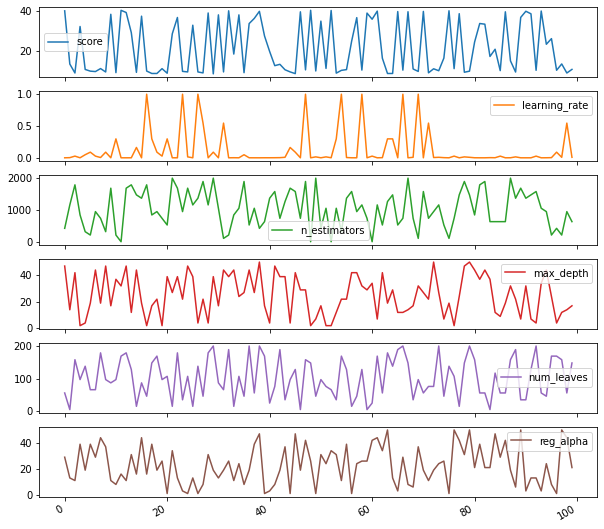

In [ ]:
# plot results
search_df = pd.DataFrame(np.transpose([-rand_search.cv_results_['mean_test_score'],
                                       rand_search.cv_results_['param_learning_rate'].data,
                                       rand_search.cv_results_['param_n_estimators'].data, 
                                       rand_search.cv_results_['param_max_depth'].data,                                      
                                       rand_search.cv_results_['param_num_leaves'].data,
                                       rand_search.cv_results_['param_reg_alpha'].data]),
                           columns=['score', 'learning_rate', 'n_estimators', 'max_depth', 'num_leaves','reg_alpha'])

search_df.plot(subplots=True,figsize=(10, 10))
plt.savefig('RandomSearchCV_tuning.png', bbox_inches='tight')

Text(0.5, 1.0, 'RMSE vs Iterations')

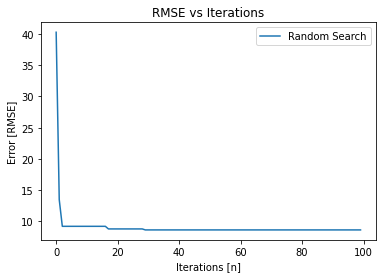

In [ ]:
store = pd.DataFrame(index=range(100)) # store scores
store['Random Search'] = search_df ['score'].cummin()
ax = store.plot()
ax.set_xlabel('Iterations [n]')
ax.set_ylabel('Error [RMSE]')
ax.set_title('RMSE vs Iterations')


## Bayesian Hyperoptimization ~ crashed at very end (ran out of time to run again)

In [ ]:
# %%time 

# # possible values of parameters
# param_grid = {'learning_rate': hp.loguniform('learning_rate', -5, 0),       # step size [0.1-1]
#               'n_estimators': hp.quniform('n_estimators', 5, 2000, 20),  # n boosted trees [0-inf]
#               'max_depth': hp.quniform('max_depth', 2, 50, 2),     # depth of tree [1-inf]
#               'num_leaves': hp.quniform('num_leaves', 5, 100, 20),   # max leaves per tree [1-inf]
#               'reg_alpha': hp.quniform('reg_alpha', 5, 20, 20),    # regularization [0-inf]
#              }

# # create function to minimize
# def hyperop_cv(params, cv=kf, X=X[train_idx], y=y[train_idx]):
    
#     # define parameters
#     params = {'learning_rate': params['learning_rate'],
#               'n_estimators': int(params['n_estimators']), 
#               'max_depth': int(params['max_depth']), 
#               'num_leaves': int(params['num_leaves']),
#               'reg_alpha': params['reg_alpha']}
    
#     hyperop_model = lgb.LGBMRegressor(random_state=0, **params) # input params into model
#     score = -cross_val_score(hyperop_model, X, y, 
#                              cv=cv, 
#                              scoring="neg_mean_squared_error",
#                              n_jobs=-1).mean()
#     return score

# # store iterative results as trials
# trials = Trials()
# best=fmin(fn = hyperop_cv, # function to optimize
#           space = param_grid, 
#           algo = tpe.suggest, # optimization algorithm (hyperop selects parameters)
#           max_evals = 100, # maximum number of iterations
#           trials = trials # store trial scores
#          )

# # calculate 
# hyperop_model = lgb.LGBMRegressor(random_state = 0, 
#                                   n_estimators = int(best['n_estimators']),
#                                   max_depth = int(best['max_depth']),
#                                   num_leaves = int(best['num_leaves']),
#                                   reg_alpha = best['reg_alpha'],
#                                   learning_rate = best['learning_rate']
#                                   )
# hyperop_model.fit(X[train_idx],y[train_idx])
# train_rmse = np.sqrt(MSE(y[train_idx], hyperop_model.predict(X[train_idx]))) # train error
# test_rmse = np.sqrt(MSE(y[test_idx], hyperop_model.predict(X[test_idx])))    # train error

# print("Best MSE {:.3f} params {}".format( hyperop_cv(best), best))

# export_kaggle_prediction(hyperop_model, 
#                          X[kaggle_ids], 
#                          'data/submit_sample.csv', 
#                          f'data/predictions/hyper_op.csv') # store results as csv


In [ ]:
# # plot results
# hyper_results = np.array([[x['result']['loss'],
#                            x['misc']['vals']['learning_rate'][0],
#                            x['misc']['vals']['n_estimators'][0],
#                            x['misc']['vals']['max_depth'][0],
#                            x['misc']['vals']['num_leaves'][0],
#                            x['misc']['vals']['reg_alpha'][0]] for x in trials.trials])


# hyper_df = pd.DataFrame(hyper_results,
#                            columns=['score', 'learning_rate','n_estimators','max_depth','num_leaves','reg_alpha'])
# hyper_df.plot(subplots=True,figsize=(10, 10))
# plt.savefig('hyper_tuning.png', bbox_inches='tight')

# Submit to Kaggle

In [ ]:
# # submit to kaggle
# !kaggle competitions submit -c flight-delays-prediction-challeng2021 -f data/predictions/lgbm_naive_OHEcat.csv -m 'lgbm_naive_OHEcat'
# !kaggle competitions submit -c flight-delays-prediction-challeng2021 -f data/predictions/lgbm_naive_LABcat.csv -m 'lgbm_naive_LABcat'
# !kaggle competitions submit -c flight-delays-prediction-challeng2021 -f data/predictions/lgbm_naive_LABcat_OHEtime.csv -m 'lgbm_naive_LABcat_OHEtime'
# !kaggle competitions submit -c flight-delays-prediction-challeng2021 -f data/predictions/lgbm_naive_LABcat_LABtime.csv -m 'lgbm_naive_LABcat_LABtime'
# !kaggle competitions submit -c flight-delays-prediction-challeng2021 -f data/predictions/lgbm_naive_LABcat_CYCtime.csv -m 'lgbm_naive_LABcat_CYCtime'
# !kaggle competitions submit -c flight-delays-prediction-challeng2021 -f data/predictions/lgbm_naive_LABcat_OHEtime_woOutliers.csv -m 'lgbm_naive_LABcat_OHEtime_woOutliers'
# !kaggle competitions submit -c flight-delays-prediction-challeng2021 -f naive_LABcat_OHEtime_FE.csv -m 'naive_LABcat_OHEtime_FE'